# Inspecting a RooWorkspace
_Valerio Ippolito - INFN Sezione di Roma_

What's inside a RooWorkspace created with HistFactory? Let's find out in two different ways.


## With ROOT
Is there a better way to understand what's inside a ROOT file than opening it? Let's see what has been created by `create_data/create_workspace.ipynb`:

In [1]:
!ls ws

ATLASIT_prova_ATLASIT_prova.root
ATLASIT_prova_combined_ATLASIT_prova_model.root
ATLASIT_prova_ljets_HThad_5j3b_ATLASIT_prova_model.root
ATLASIT_prova_ljets_Mbb_ge6jge4b_ATLASIT_prova_model.root
ATLASIT_prova_results.table



The output folder of a HistFactory run usually contains many files, one of which is quite meaningful: it's the one with the name `combined`.

In [2]:
f = new TFile("ws/ATLASIT_prova_combined_ATLASIT_prova_model.root")


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

(TFile *) @0x7f2d78ff7a78


In [3]:
f->ls()

TFile**		ws/ATLASIT_prova_combined_ATLASIT_prova_model.root	
 TFile*		ws/ATLASIT_prova_combined_ATLASIT_prova_model.root	
  KEY: RooWorkspace	combined;1	combined
  KEY: TProcessID	ProcessID0;1	e19480e0-f09e-11ec-8ff8-380011acbeef
  KEY: TDirectoryFile	ljets_HThad_5j3b_hists;1	ljets_HThad_5j3b_hists
  KEY: TDirectoryFile	ljets_Mbb_ge6jge4b_hists;1	ljets_Mbb_ge6jge4b_hists
  KEY: RooStats::HistFactory::Measurement	ATLASIT_prova;1	ATLASIT_prova


The file contains:
- the `RooWorkspace` object, i.e. our likelihood model and associated datasets
- another object we shall neglect
- two directories containing the input histograms we used to build the workspace, one per channel (statistically independent set of data, cf. previous steps of this tutorial)
- the Measurement object representing what we created with create_workspace.ipynb, so effectively the specification of what is inside the Workspace

In case you ever panick and don't remember what's inside a workspace, you may do

In [4]:
ATLASIT_prova->PrintXML("blabla")

[#2] PROGRESS:HistFactory -- Printing XML Files for measurement: ATLASIT_prova
[#2] PROGRESS:HistFactory -- Printing XML Files for channel: ljets_HThad_5j3b
[#2] PROGRESS:HistFactory -- Finished printing XML files
[#2] PROGRESS:HistFactory -- Printing XML Files for channel: ljets_Mbb_ge6jge4b
[#2] PROGRESS:HistFactory -- Finished printing XML files
[#2] PROGRESS:HistFactory -- Finished printing XML files


and then the `blabla` folder (which is created just in case) contains the XML files which specify, in some convoluted version of the English language, what's inside the workspace:

In [5]:
!ls blabla

ATLASIT_prova_ljets_HThad_5j3b.xml    ATLASIT_prova.xml
ATLASIT_prova_ljets_Mbb_ge6jge4b.xml



In [6]:
!cat blabla/ATLASIT_prova.xml

<!--
This xml file created automatically on: 
2022-6-20
-->
<!DOCTYPE Combination  SYSTEM 'HistFactorySchema.dtd'>

<Combination OutputFilePrefix="./ws/ATLASIT_prova" >


  <Input>./blabla/ATLASIT_prova_ljets_HThad_5j3b.xml</Input>
  <Input>./blabla/ATLASIT_prova_ljets_Mbb_ge6jge4b.xml</Input>

  <Measurement Name="ATLASIT_prova" Lumi="1" LumiRelErr="0" ExportOnly="True"  >
    <POI>mu_ttH</POI>  
    <ParamSetting Const="True">Lumi</ParamSetting>
  </Measurement> 

</Combination>



Now, back on the workspace, which is usually called `combined`. What's inside it? We check it with

In [7]:
w = dynamic_cast<RooWorkspace*>(f->Get("combined"));
w->Print("")


RooWorkspace(combined) combined contents

variables
---------
(Lumi,alpha_JES_Scenario1_NP1,alpha_lumi,alpha_stXsec,alpha_ttXsec,binWidth_obs_x_ljets_HThad_5j3b_0,binWidth_obs_x_ljets_HThad_5j3b_1,binWidth_obs_x_ljets_HThad_5j3b_2,binWidth_obs_x_ljets_Mbb_ge6jge4b_0,binWidth_obs_x_ljets_Mbb_ge6jge4b_1,binWidth_obs_x_ljets_Mbb_ge6jge4b_2,channelCat,mu_tt,mu_ttH,nom_alpha_JES_Scenario1_NP1,nom_alpha_lumi,nom_alpha_stXsec,nom_alpha_ttXsec,nominalLumi,obs_x_ljets_HThad_5j3b,obs_x_ljets_Mbb_ge6jge4b,weightVar)

p.d.f.s
-------
RooGaussian::alpha_JES_Scenario1_NP1Constraint[ x=alpha_JES_Scenario1_NP1 mean=nom_alpha_JES_Scenario1_NP1 sigma=1 ] = 1
RooGaussian::alpha_lumiConstraint[ x=alpha_lumi mean=nom_alpha_lumi sigma=1 ] = 1
RooGaussian::alpha_stXsecConstraint[ x=alpha_stXsec mean=nom_alpha_stXsec sigma=1 ] = 1
RooGaussian::alpha_ttXsecConstraint[ x=alpha_ttXsec mean=nom_alpha_ttXsec sigma=1 ] = 1
RooRealSumPdf::ljets_HThad_5j3b_model[ binWidth_obs_x_ljets_HThad_5j3b_0 * L_x_ttH_ljets_HTh

The workspace is actually a collection of stuff:
- variables (which can be parameters, observables, constants... anything!)
- probability density functions (PDFs), i.e. mathematical functions of those variables (technically there is no distinction between observables and parameters at this stage)
- functions, which - differently from PDFs - aren't supposed to be normalized to 1 (for example, a histogram can be seen as a function of an observable, whose integral is equal to a given number of events)
- datasets, i.e. real data (the `Data` input histograms we gave when creating the workspace) and so-called Asimov data, which represent the overall _nominal_ background expectation;
- embedded datasets, i.e. internal representations of histograms
- parameter snapshots, i.e. "named copies" of the value (e.g. `9.888`) and settings (e.g. up and down error, `isConstant=kTRUE`) of a set of parameters
- named sets, i.e. "named sets" of parameters, which share the same meaning - e.g. "what's or what are the POI[s]", "which are the observables", etc.
- generic objects, like the notable HistFactory `ModelConfig` object, which represents how we should be putting together the overall likelihood model (PDF, data, and notion of who's the POI and who are the observable, the nuisance parameters and the constant parameters in our statistical task)

Please note that the meaning of _nominal_ depends strongly on the default parameters which were set in the creation of the workspace. More specifically: normalization parameters (such as the signal strength, which is usually the POI, and the background normalization factors) are taken at their nominal value as declared in the workspace creation. Typical mistake: expecting the Asimov dataset to represent the _background-only hypothesis_ when you set the signal strength default value to `1`.

We can for example identify what's the POI, and what are its default value and bounds:

In [8]:
w->set("ModelConfig_POI")->Print("v")

  1) 0x7f2d5a29fc10 RooRealVar:: mu_ttH = 0  L(-10 - 20)  "mu_ttH"


or understand what are the observables,

In [9]:
w->set("observables")->Print("v")

  1) 0x7f2d5a251f00 RooRealVar::   obs_x_ljets_HThad_5j3b = 0.9  L(0 - 1) B(5)  "obs_x_ljets_HThad_5j3b"
  2) 0x7f2d5a2a47e0 RooRealVar:: obs_x_ljets_Mbb_ge6jge4b = 0.95  L(0 - 1) B(10)  "obs_x_ljets_Mbb_ge6jge4b"
  3) 0x7f2d5a683870 RooRealVar::                weightVar = 0  L(-1e+10 - 1e+10)  "weightVar"
  4) 0x7f2d59c90520 RooCategory::               channelCat = ljets_Mbb_ge6jge4b(idx = 1)
  "channelCat"


or we may do that via the ModelConfig object,

In [10]:
mc = dynamic_cast<RooStats::ModelConfig*>(w->obj("ModelConfig"));
mc->GetParametersOfInterest()->Print();
mc->GetObservables()->Print();

RooArgSet:: = (mu_ttH)
RooArgSet:: = (obs_x_ljets_HThad_5j3b,obs_x_ljets_Mbb_ge6jge4b,weightVar,channelCat)


and inspect the variable info via

In [11]:
w->var("mu_ttH")->Print()

RooRealVar::mu_ttH = 0  L(-10 - 20) 


We can also perform some simple plotting, provided we choose the observables to look at. HistFactory workspaces always have two special ones:
- `channelCat` represents the category the events fall in (i.e. it's like an enum representing which of the various channels events belong to - for two channels, you'll see two _Possible states_ this discrete variable can take)
- `weightVar` represents instead the weight which may be associated to each event

In [12]:
w->cat("channelCat")->Print("v")

--- RooAbsArg ---
  Value State: clean
  Shape State: clean
  Attributes: 
  Address: 0x7f2d59c90520
  Clients: 
    (0x7f2d59ffa5a0,V-) RooSimultaneous::simPdf ""
  Servers: 
  Proxies: 
--- RooAbsCategory ---
  Value = 1 "ljets_Mbb_ge6jge4b)
  Possible states:
    ljets_HThad_5j3b	0
    ljets_Mbb_ge6jge4b	1


Verbose printouts (`Print("v")`) and tree printouts (`Print("t")`) help nerds understand what's going on - how a variable or a function or in general any RooFit object is defined, which functions use it, and so on and so forth.

In any case, HistFactory creates observables with a standard naming, like `obs_x_ljets_HThad_5j3b`, so we may plot data in this variable, superimposing the result of the fit of the _overall signal plus background model_ (S+B model) to the full data in the different categories. The PDF representing this overall model is called by HistFactory `simPdf`.

We will actually do two things:
- fit with the S+B model (red PDF)
- fit with the B-only model (blue PDF)

In [13]:
// fit to the full S+B model
dataset = w->data("obsData");

w->var("mu_ttH")->setVal(0);
w->var("mu_ttH")->setConstant(kFALSE);
w->pdf("simPdf")->fitTo(*dataset);

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooProdPdf::getConstraints(model_ljets_HThad_5j3b) omitting term lumiConstraint as constraint term as it does not share any parameters with the other pdfs in product. To force inclusion in likelihood, add an explicit Constrain() argument for the target parameter
[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_simPdf_FOR_OBS_channelCat:obs_x_ljets_HThad_5j3b:obs_x_ljets_Mbb_ge6jge4b with 4 entries
[#1] INFO:Minization --  Including the following constraint terms in minimization: (alpha_lumiConstraint,alpha_ttXsecConstraint,alpha_JES_Scenario1_NP1Constraint,alpha_stXsecConstraint)
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_obsData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
RooAbsTestStatistic::initSim

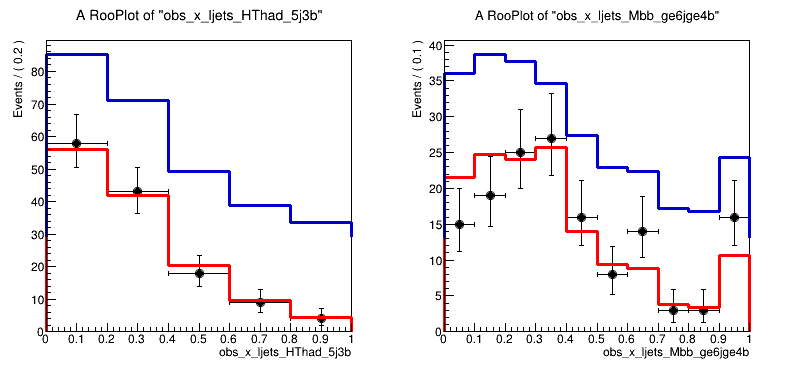

[#1] INFO:Plotting -- RooTreeData::plotOn: plotting 132 events out of 278 total events
[#1] INFO:Plotting -- RooSimultaneous::plotOn(simPdf) plot on obs_x_ljets_HThad_5j3b represents a slice in the index category (channelCat)
[#1] INFO:Plotting -- RooAbsReal::plotOn(model_ljets_HThad_5j3b) slice variable channelCat was not projected anyway
[#1] INFO:NumericIntegration -- RooRealIntegral::init(ljets_HThad_5j3b_model_Int[obs_x_ljets_HThad_5j3b]) using numeric integrator RooBinIntegrator to calculate Int(obs_x_ljets_HThad_5j3b)
[#1] INFO:Plotting -- RooTreeData::plotOn: plotting 146 events out of 278 total events
[#1] INFO:Plotting -- RooSimultaneous::plotOn(simPdf) plot on obs_x_ljets_Mbb_ge6jge4b represents a slice in the index category (channelCat)
[#1] INFO:Plotting -- RooAbsReal::plotOn(model_ljets_Mbb_ge6jge4b) slice variable channelCat was not projected anyway
[#1] INFO:NumericIntegration -- RooRealIntegral::init(ljets_Mbb_ge6jge4b_model_Int[obs_x_ljets_Mbb_ge6jge4b]) using numeric

In [14]:
c = new TCanvas("c", "c", 800, 400);
c->Divide(2, 1);

cat = w->cat("channelCat");

frame = w->var("obs_x_ljets_HThad_5j3b")->frame();
dataset->plotOn(frame, RooFit::Name("observed data"), RooFit::Cut("channelCat==channelCat::ljets_HThad_5j3b"));
w->pdf("simPdf")->plotOn(frame, RooFit::Slice(*cat, "ljets_HThad_5j3b"), RooFit::ProjWData(*cat, *dataset), RooFit::Name("PDF after S+B fit"), RooFit::LineColor(kRed));

frame2 = w->var("obs_x_ljets_Mbb_ge6jge4b")->frame();
dataset->plotOn(frame2, RooFit::Name("observed data"), RooFit::Cut("channelCat==channelCat::ljets_Mbb_ge6jge4b"));
w->pdf("simPdf")->plotOn(frame2, RooFit::Slice(*cat, "ljets_Mbb_ge6jge4b"), RooFit::ProjWData(*cat, *dataset), RooFit::Name("PDF after S+B fit"), RooFit::LineColor(kRed));

// now, fit with POI set to zero
w->var("mu_ttH")->setVal(0);
w->var("mu_ttH")->setConstant(kTRUE);
w->pdf("simPdf")->fitTo(*dataset);

w->pdf("simPdf")->plotOn(frame, RooFit::ProjWData(*cat, *dataset), RooFit::Name("PDF after B-only fit"), RooFit::LineColor(kBlue+1));
w->pdf("simPdf")->plotOn(frame2, RooFit::ProjWData(*cat, *dataset), RooFit::Name("PDF after B-only fit"), RooFit::LineColor(kBlue+1));

c->cd(1);
frame->Draw();
c->cd(2);
frame2->Draw();

c->Draw();

## With CommonStatTools

The CommonStatTools package provides a simple tool to extract histograms out of the folder structure of the file containing the RooWorkspace, and put them out in a single ROOT file.

In [15]:
!python ../CommonStatTools/obtainHistosFromWS.py -i ws/ATLASIT_prova_combined_ATLASIT_prova_model.root -o validation_histos.root




RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 


                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University


                All rights reserved, please read http://roofit.sourceforge.net/license.txt







In [16]:
!ls

blabla               create_workspace.ipynb   mytest.root             ws
create_inputs.ipynb  inspect_workspace.ipynb  validation_histos.root  xml



In [17]:
f_histo = new TFile("validation_histos.root");
f_histo->ls();

TFile**		validation_histos.root	
 TFile*		validation_histos.root	
  KEY: TH1D	ljets_HThad_5j3b_Data_regBin;1	h
  KEY: TH1D	ljets_HThad_5j3b_ttH_regBin;1	h
  KEY: TH1D	ljets_HThad_5j3b_ttbar_regBin;1	h
  KEY: TH1D	ljets_HThad_5j3b_ttbar_JES_Scenario1_NP1_Shape_Down_regBin;1	h
  KEY: TH1D	ljets_HThad_5j3b_ttbar_JES_Scenario1_NP1_Shape_Up_regBin;1	h
  KEY: TH1D	ljets_HThad_5j3b_singleTop_regBin;1	h
  KEY: TH1D	ljets_Mbb_ge6jge4b_Data_regBin;1	h
  KEY: TH1D	ljets_Mbb_ge6jge4b_ttH_regBin;1	h
  KEY: TH1D	ljets_Mbb_ge6jge4b_ttbar_regBin;1	h
  KEY: TH1D	ljets_Mbb_ge6jge4b_ttbar_JES_Scenario1_NP1_Shape_Down_regBin;1	h
  KEY: TH1D	ljets_Mbb_ge6jge4b_ttbar_JES_Scenario1_NP1_Shape_Up_regBin;1	h
  KEY: TH1D	ljets_Mbb_ge6jge4b_singleTop_regBin;1	h


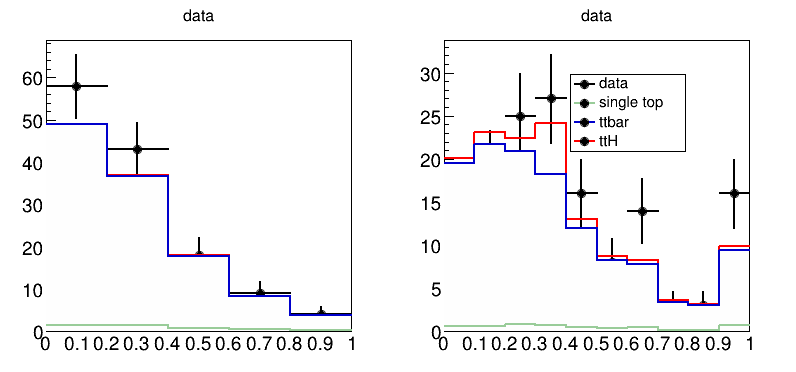

In [18]:
c = new TCanvas("c2", "c", 800, 400);
c->Divide(2, 1);

// first channel
c->cd(1);
h_data = dynamic_cast<TH1D*>(f_histo->Get("ljets_HThad_5j3b_Data_regBin"));
h_ttH = dynamic_cast<TH1D*>(f_histo->Get("ljets_HThad_5j3b_ttH_regBin"));
h_ttbar = dynamic_cast<TH1D*>(f_histo->Get("ljets_HThad_5j3b_ttbar_regBin"));
h_singleTop = dynamic_cast<TH1D*>(f_histo->Get("ljets_HThad_5j3b_singleTop_regBin"));

h_ttH->SetLineColor(kRed);
h_ttbar->SetLineColor(kBlue+1);
h_singleTop->SetLineColor(kGreen-8);
h_ttH->SetTitle("ttH");
h_ttbar->SetTitle("ttbar");
h_singleTop->SetTitle("single top");
h_data->SetTitle("data");

h_data->Draw("pe");
auto S_plus_B = new THStack("S_plus_B", "S plus B");
S_plus_B->Add(h_singleTop);
S_plus_B->Add(h_ttbar);
S_plus_B->Add(h_ttH);
S_plus_B->Draw("hist same");


// second channel
c->cd(2);
h_data = dynamic_cast<TH1D*>(f_histo->Get("ljets_Mbb_ge6jge4b_Data_regBin"));
h_ttH = dynamic_cast<TH1D*>(f_histo->Get("ljets_Mbb_ge6jge4b_ttH_regBin"));
h_ttbar = dynamic_cast<TH1D*>(f_histo->Get("ljets_Mbb_ge6jge4b_ttbar_regBin"));
h_singleTop = dynamic_cast<TH1D*>(f_histo->Get("ljets_Mbb_ge6jge4b_singleTop_regBin"));

h_ttH->SetLineColor(kRed);
h_ttbar->SetLineColor(kBlue+1);
h_singleTop->SetLineColor(kGreen-8);
h_ttH->SetTitle("ttH");
h_ttbar->SetTitle("ttbar");
h_singleTop->SetTitle("single top");
h_data->SetTitle("data");

h_data->Draw("pe");
auto S_plus_B2 = new THStack("S_plus_B", "S plus B");
S_plus_B2->Add(h_singleTop);
S_plus_B2->Add(h_ttbar);
S_plus_B2->Add(h_ttH);
S_plus_B2->Draw("hist same");


c->cd(2)->BuildLegend();
c->Draw();

You may sometimes need to compare different versions of the same workspace. In this case, a convenient way to identify changes in histograms is provided by CommonStatTools: let's first create a second mockup workspace,

In [1]:
!cp ws/ATLASIT_prova_combined_ATLASIT_prova_model.root another_mysterious_ws.root

and then we can visualize the differences between the histograms contained in the "old" (`-o`) and "new" (`-n`) files:

In [7]:
!python ../CommonStatTools/compareHistos.py -o ws/ATLASIT_prova_combined_ATLASIT_prova_model.root -n another_mysterious_ws.root




RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 


                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University


                All rights reserved, please read http://roofit.sourceforge.net/license.txt








Elements only in ws/ATLASIT_prova_combined_ATLASIT_prova_model.root:





Elements only in another_mysterious_ws.root:





Common elements:


  ljets_HThad_5j3b_hists_data_ljets_HThad_5j3b_Data_regBin


    number of bins: identical


    x-axis min: 0.000 vs 0.000


    x-axis max: identical


    integral: identical


    mean: identical


    rms: identical


  ljets_HThad_5j3b_hists_singleTop_ljets_HThad_5j3b_singleTop_regBin


    number of bins: identical


    x-axis min: 0.000 vs 0.000


    x-axis max: identical


    integral: identical


    mean: identical


    rms: identical


  ljets_HThad_5j3b_hists_ttH_ljets_HThad_5j3b_ttH_regBin


    number of bins: identical


    x-axis min: 0.000 vs 0.000


    x-axis ma

Of course there may be residual differences due to different settings in terms of normalization factors or normalization uncertainties, but that might be checked for example by comparing the XML files which can be extracted a-posteriori from the `Measurement` object in the file (`vimdiff` them!).